In [2]:
# Standard libraries
import io
import os
import time
import warnings
import contextlib

# Data processing libraries
import numpy as np
import pandas as pd

# Natural Language Processing libraries
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Machine Learning and Model Evaluation libraries
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score,
    accuracy_score, 
    f1_score, 
    classification_report,
    confusion_matrix,
    mutual_info_score, 
)
from sklearn.feature_selection import mutual_info_regression

# Visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Miscellaneous
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import torch
import umap

# Collaborative Filtering and Recommendation Systems
from surprise import Dataset, Reader, SVD, KNNBasic, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise.accuracy import rmse

# Suppress warnings for better clarity
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
d:\Python_Environment\Anaconda3\envs\EODP-2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Why Classification is bad for RS

Recommender systems would no longer be able to use Classification models, since the main purpose of recommender systems is to predict ratings.

Then Classification model can only predict 1 score as 0/1/2/3/4 .... In the Classification model, only 1 point can be predicted as 0/1/2/3/4, etc., while in the Regression model, 1 point can be predicted as 1.1, 1.08, etc.

This radically reduces the possibility of error. Here is a Classification-based recommender system that works very, very poorly

In [3]:
train_X = pd.read_csv('Data-Files\\BX-Preprocessed.csv')
test_X = pd.read_csv('Data-Files\\BX-NewPreprocessed.csv')
X_train = (pd.read_csv('Data-Files\\BX-Preprocessed.csv')).drop(columns=['ISBN', 'Book-Rating'])
y_train = (pd.read_csv('Data-Files\\BX-Preprocessed.csv'))['Book-Rating']
X_test = (pd.read_csv('Data-Files\\BX-NewPreprocessed.csv')).drop(columns=['ISBN', 'Book-Rating'])
y_test = (pd.read_csv('Data-Files\\BX-NewPreprocessed.csv'))['Book-Rating']
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
dt_probabilities = dt_classifier.predict_proba(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, dt_probabilities[:,1]))  
print('Decision Tree Classifier RMSE:', rmse_dt)
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
knn_probabilities = knn_classifier.predict_proba(X_test)
rmse_knn = np.sqrt(mean_squared_error(y_test, knn_probabilities[:,1])) 
print('KNN Classifier RMSE:', rmse_knn)

Decision Tree Classifier RMSE: 7.781622242860937
KNN Classifier RMSE: 7.7827514846278705


WORKS TOOOOOOOOO BAD！！！！

# Recommendation: Find Similarity

For recommender systems, we can no longer use Accuracy and F1-Score as evaluation metrics and should use RMSE

# 1. Machine Learning Method

## 1.1. Data Loading and Preparation

In [21]:
train_file = 'Data-Files\\BX-Preprocessed.csv'
test_file = 'Data-Files\\BX-NewPreprocessed.csv'

def prepare_data(train_file, test_file, sample_size=10000, random_state=42):
    reader = Reader(rating_scale=(1, 10))
    train_X_sample = pd.read_csv(train_file).sample(n=sample_size, random_state=random_state)
    test_X_sample = pd.read_csv(test_file).sample(n=sample_size, random_state=random_state)
    train_data = Dataset.load_from_df(train_X_sample[['User-ID', 'ISBN', 'Book-Rating']], reader)
    test_data = Dataset.load_from_df(test_X_sample[['User-ID', 'ISBN', 'Book-Rating']], reader)
    trainset = train_data.build_full_trainset()
    testset = test_data.build_full_trainset().build_testset()
    return trainset, testset

trainset, testset = prepare_data(train_file, test_file, sample_size=10000, random_state=42)

## 1.2. KNN Based Model

| Recommendation System Type |                           Example                            |
| :------------------------: | ---------------------------------------------------------- |
|         Item-Based         | If user A highly rates Harry Potter, recommend more fantasy novels to them. |
|         User-Based         | User A likes Harry Potter, and user B is determined to have a similar taste to user A, so Harry Potter is recommended to user B. |

### 1.2.1. K Parameter Optimization

In [17]:
def optimize_model(train_data, user_based=True):
    with contextlib.redirect_stdout(io.StringIO()):
        k_values = np.arange(1, 101)
        results = []
        for k in tqdm(k_values, desc="Training User-Based KNN" if user_based else "Training Item-Based KNN"):
            sim_options = {'name': 'msd', 'user_based': user_based}
            model = KNNBasic(k=k, sim_options=sim_options)
            cv_results = cross_validate(model, train_data, measures=['RMSE'], cv=5, verbose=False)
            mean_rmse = np.mean(cv_results['test_rmse'])
            results.append(mean_rmse)
        optimal_k = k_values[np.argmin(results)]
    return k_values, results, results, optimal_k, sim_options

k_values_user, results_user, results_user, optimal_k_user, sim_options_user = optimize_model(train_data, user_based=True)
k_values_item, results_item, results_item, optimal_k_item, sim_options_item = optimize_model(train_data, user_based=False)

Training Item-Based KNN: 100%|██████████| 100/100 [01:50<00:00,  1.10s/it]


### 1.2.2. Visualization of RMSE vs. k Values

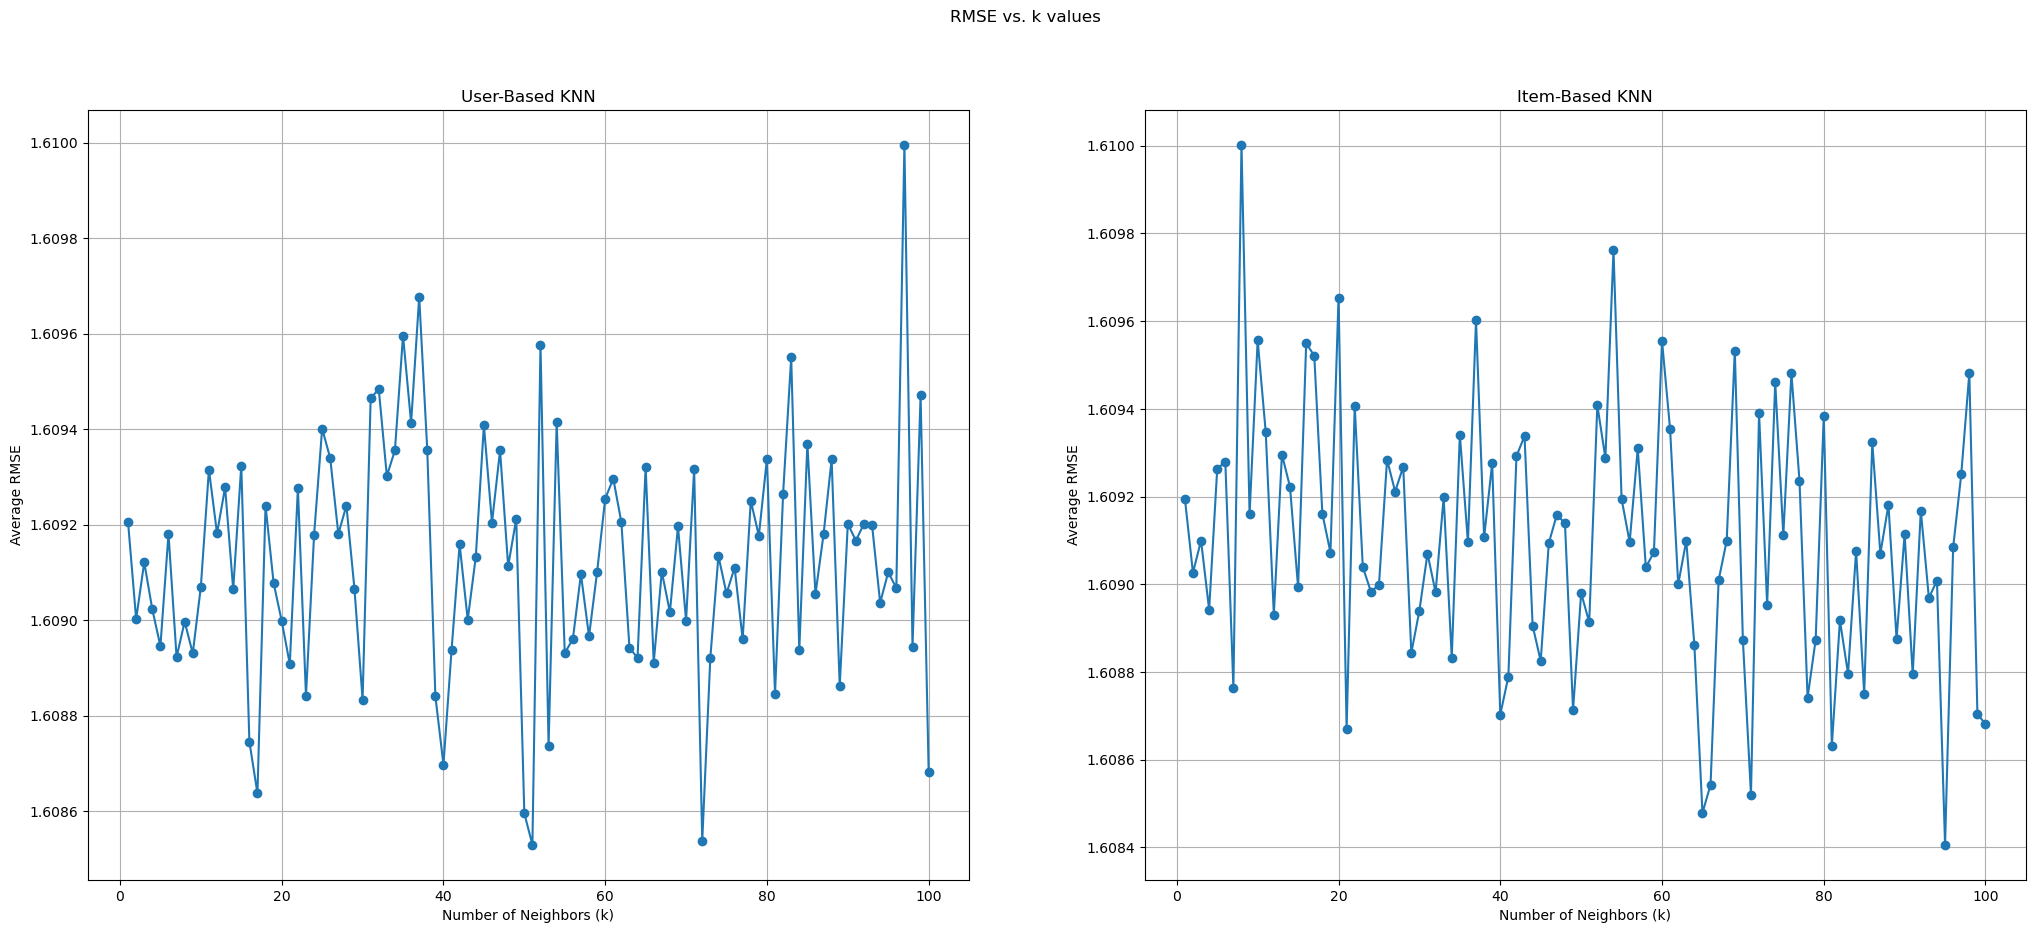

In [22]:
def plot_rmse_vs_k(k_values_user, results_user, k_values_item, results_item):
    plt.figure(figsize=(25, 10))
    plt.subplot(1, 2, 1)
    plt.plot(k_values_user, results_user, marker='o')
    plt.title('User-Based KNN')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Average RMSE')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(k_values_item, results_item, marker='o')
    plt.title('Item-Based KNN')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Average RMSE')
    plt.grid(True)
    plt.suptitle('RMSE vs. k values')
    plt.savefig('Plots_NewBook/RMSE_vs_k_values.png')
    plt.show()
plot_rmse_vs_k(k_values_user, results_user, k_values_item, results_item)

## 1.2.3. RMSE After Optimized for XXX-Based KNN

In [23]:
def train_and_evaluate_final_model(trainset, testset, optimal_k, sim_options):
    with contextlib.redirect_stdout(io.StringIO()):
        model = KNNBasic(k=optimal_k, sim_options=sim_options)
        model.fit(trainset)
        predictions = model.test(testset)
        final_rmse = accuracy.rmse(predictions, verbose=False)
    return final_rmse


final_rmse_user = train_and_evaluate_final_model(trainset, testset, optimal_k_user, sim_options_user) # User-Based
print("Final RMSE:", final_rmse_user)
final_rmse_item = train_and_evaluate_final_model(trainset, testset, optimal_k_item, sim_options_item) # Item-Based
print("Final RMSE:", final_rmse_item)

Final RMSE: 1.6636379413802753
Final RMSE: 1.6636379413802753


## 1.3. SVD Based Model

SVD is a matrix decomposition technique that is often regarded as a non-preferred (i.e., not particularly favoring either user-based or item-based methods) approach in recommender systems.

It discovers potential relationships between users and items by decomposing the scoring matrix, which can capture both user and item characteristics.

RMSE: 1.5995
RMSE: 1.5864


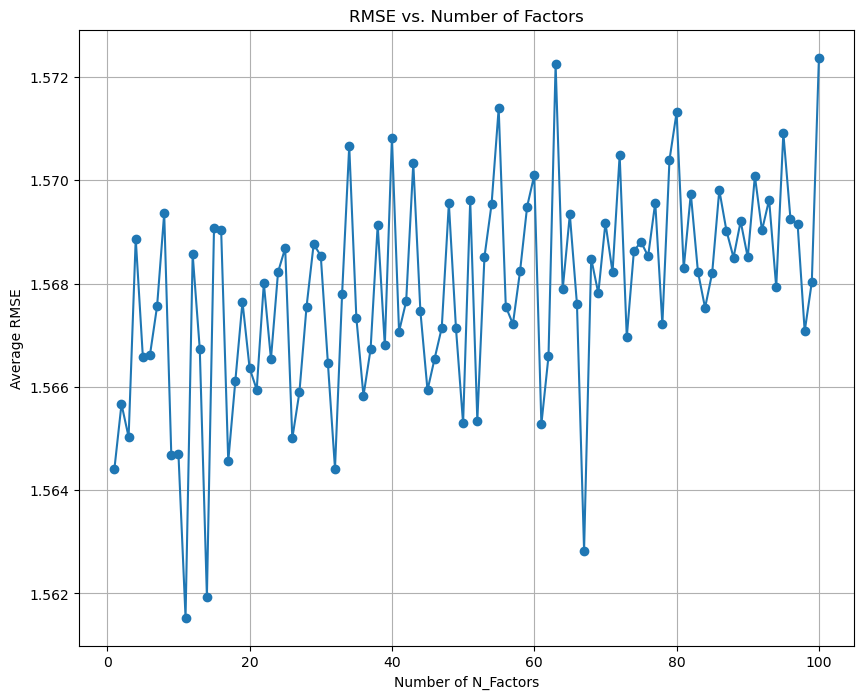

In [27]:
# 1. 加载数据
train_X_sample = pd.read_csv('Data-Files\\BX-Preprocessed.csv').sample(n=10000, random_state=42)
reader = Reader(rating_scale=(1, 10))
train_data = Dataset.load_from_df(train_X_sample[['User-ID', 'ISBN', 'Book-Rating']], reader)
trainset = train_data.build_full_trainset()
test_X_sample = pd.read_csv('Data-Files\\BX-NewPreprocessed.csv').sample(n=10000, random_state=42)
test_data = Dataset.load_from_df(test_X_sample[['User-ID', 'ISBN', 'Book-Rating']], reader)
testset = test_data.build_full_trainset().build_testset()

# 1.3. SVD Based Model
# Recommendation_ml_svd()

# 1.3.1. 训练SVD + 交叉验证找到最佳参数
# Recommendation_ml_svd_cv()
model = SVD()
model.fit(trainset)
predictions = model.test(testset)
initial_rmse = accuracy.rmse(predictions)
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30, 40],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1]
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(train_data)

# 1.3.2. 使用最佳参数重新训练模型 + 最佳模型评估
# Recommendation_ml_svd_best()
best_svd = SVD(
    n_factors=gs.best_params['rmse']['n_factors'], 
    n_epochs=gs.best_params['rmse']['n_epochs'],
    lr_all=gs.best_params['rmse']['lr_all'], 
    reg_all=gs.best_params['rmse']['reg_all']
)
best_svd.fit(trainset)
predictions = best_svd.test(testset)
optimized_rmse = accuracy.rmse(predictions)

# 1.3.3. 可视化N_Factors数量与RMSE的关系
# Recommendation_ml_svd_plot()
n_factors_values = np.arange(1, 101)  # 改为从1到100
results = []
for n_factors in n_factors_values:
    model = SVD(n_factors=n_factors, n_epochs=20, lr_all=0.005, reg_all=0.02)
    cv_results = cross_validate(model, train_data, measures=['RMSE'], cv=3, verbose=False)
    mean_rmse = np.mean(cv_results['test_rmse'])
    results.append(mean_rmse)
plt.figure(figsize=(10, 8))
plt.plot(n_factors_values, results, marker='o', linestyle='-')
plt.title('RMSE vs. Number of Factors')
plt.xlabel('Number of N_Factors')
plt.ylabel('Average RMSE')
plt.grid(True)
plt.show()





# 2. Dense Layers NN Based Model 

NN aka neural network

Recormand books with similar content (Title/Publisher/Author) to the user

相比于传统的全连接层网络，优化在于

1. 使用LeakyReLU作为激活函数

2. 采用RMSprop优化器

3. 使用ReduceLROnPlateau回调函数

Epoch 1/25
5104/5104 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 4.1123 - rmse: 1.9053 - val_loss: 2.6831 - val_rmse: 1.6145 - learning_rate: 0.0010
Epoch 2/25
5104/5104 ━━━━━━━━━━━━━━━━━━━━ 5s 967us/step - loss: 2.6517 - rmse: 1.6246 - val_loss: 2.6401 - val_rmse: 1.6051 - learning_rate: 0.0010
Epoch 3/25
5104/5104 ━━━━━━━━━━━━━━━━━━━━ 5s 971us/step - loss: 2.6205 - rmse: 1.6148 - val_loss: 2.6530 - val_rmse: 1.6063 - learning_rate: 0.0010
Epoch 4/25
5104/5104 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 2.6263 - rmse: 1.6176 - val_loss: 2.6398 - val_rmse: 1.6083 - learning_rate: 0.0010
Epoch 5/25
5104/5104 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 2.6122 - rmse: 1.6157 - val_loss: 2.6453 - val_rmse: 1.6088 - learning_rate: 0.0010
Epoch 6/25
5104/5104 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 2.6137 - rmse: 1.6168 - val_loss: 2.6445 - val_rmse: 1.6136 - learning_rate: 0.0010
Epoch 7/25
5104/5104 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 2.5992 - rmse: 1.6126 - val_loss: 2.6394 - val_rmse: 1.608

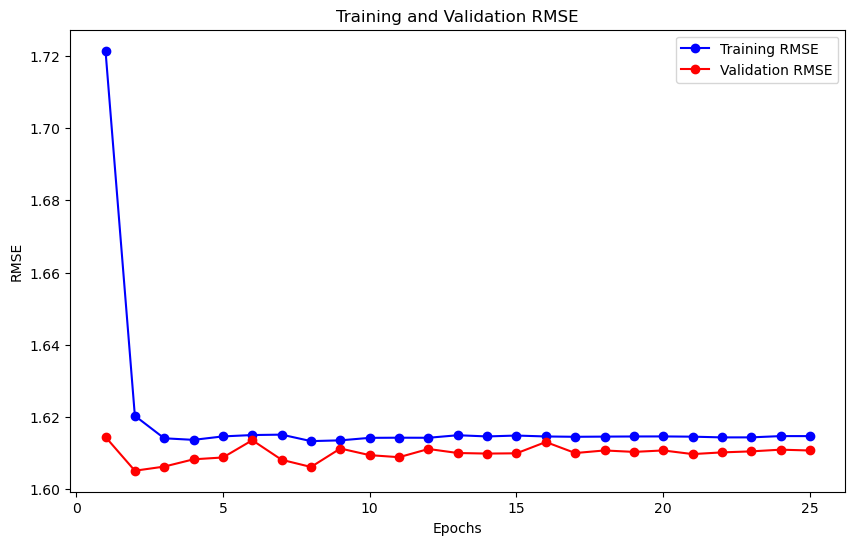

In [29]:
# 2. Dense Layers NN Based Model 
# Recommendation_dl()



# 2.1. 数据加载与准备
# Recommendation_dl_data()
warnings.filterwarnings('ignore')
train_df = pd.read_csv('Data-Files\\BX-Preprocessed.csv')
test_df = pd.read_csv('Data-Files\\BX-NewPreprocessed.csv')
X_train = train_df[['Book-Author-Encoded', 'Book-Publisher-Encoded', 'Book-Title-Embeddings']].values
X_test = test_df[['Book-Author-Encoded', 'Book-Publisher-Encoded', 'Book-Title-Embeddings']].values
y_train = train_df['Book-Rating'].values.astype('float32')  # 转换为float32
y_test = test_df['Book-Rating'].values.astype('float32')  # 转换为float32
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2.2. 构建和编译模型
# Recommendation_dl_model()
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.01),  # 使用LeakyReLU作为激活函数
    Dropout(0.2),
    Dense(64),
    LeakyReLU(alpha=0.01),  # 使用LeakyReLU作为激活函数
    Dropout(0.2),
    Dense(32),
    LeakyReLU(alpha=0.01),  # 使用LeakyReLU作为激活函数
    Dense(1)  # 因为是回归问题，最后一层不用激活函数
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 定义RMSE评价指标
def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

# 自定义Adam优化器
rmsprop_optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-7, momentum=0.0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_delta=0.01, mode='min', min_lr=1e-6)
model.compile(optimizer=rmsprop_optimizer, loss='mse', metrics=[rmse])

# 然后继续你的训练和评估过程
history = model.fit(
    X_train, 
    y_train, 
    epochs=25, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[reduce_lr]  # 加入回调函数
)
test_loss, test_rmse = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test RMSE: {test_rmse}")

# 进行预测
predictions = model.predict(X_test)


# 提取训练和验证RMSE
train_rmse = history.history['rmse']
val_rmse = history.history['val_rmse']
epochs = range(1, len(train_rmse) + 1)

# 绘制RMSE曲线
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_rmse, 'bo-', label='Training RMSE')
plt.plot(epochs, val_rmse, 'ro-', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()